# RAVLT and catFR1 Analyses

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
import scipy
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from cmlreaders import CMLReader, get_data_index
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Loading and Analyzing Data

In [2]:
df = pd.read_csv("RAVLT_w_age.csv")
df['Subject'] = df['Subject Number']
df['RAVLT total recall'] = df['Total Learning Lists 1-5']
# cvlt = df.drop(['subject_number', 'redcap_event_name', 'preop_1to5_raw'], axis = 1)
rav = df[['Subject', 'RAVLT total recall']]
rav = rav.dropna().reset_index()
rav_subs = rav['Subject'].unique()

df = get_data_index("r1")
catFR1_subs=df[df['experiment']=='catFR1']['subject'].unique() # all FR1 subjects
exp = 'catFR1' 

catFR_subs=[]
catFR_subs = list(catFR1_subs)
print('Total number of FR subjects: ', len(catFR_subs))

cat_subs = []
for sub in catFR_subs:
    temp = int(sub[2:5])
    cat_subs.append(temp)

temporary = []
for sub in cat_subs:
    if(np.isin(sub, rav_subs)):
        temporary.append(sub)
    else:
        temporary.append(np.nan)

both = []
for i, sub in enumerate(catFR_subs):
    if(~np.isnan(temporary[i])):
        both.append(sub)

evs = pd.DataFrame()
count = 0
for i, sub in enumerate(both):
    count += 1
    subject = sub
    exp = 'catFR1'
    df_select = df[(df['subject']==subject) & (df['experiment']==exp)]
    sessions = list(df[(df['subject']==subject) & (df['experiment']==exp)]['session'])
    for sess in sessions:
        try:
            reader = CMLReader(subject, exp, sess)
            evs = evs.append(reader.load('events'))
        except:
            print(sub + "_" + str(sess) + ' failed miserably >:O')

cat = evs.loc[evs['type'] == 'WORD']
recall_list = cat.groupby(['subject', 'session', 'list'])['recalled'].mean().reset_index()
recall_sess = recall_list.groupby(['subject', 'session'])['recalled'].mean().reset_index()
recall_sub = recall_sess.groupby('subject')['recalled'].mean().reset_index()
sub_codes = recall_sub['subject'].unique()
sub_num = []
for sub in sub_codes:
    sub_num.append(int(sub[2:5]))
recall_sub['sub_num'] = pd.Series(sub_num)
recall_subi = recall_sub.set_index('sub_num')


corr = rav.set_index('Subject').drop('index', 1)
corr['catFR1 Total Recall'] = recall_subi['recalled']*100
corr = corr.dropna().loc[corr['RAVLT total recall'] != '<35']
corr['RAVLT total recall'] = corr['RAVLT total recall'].astype(float)/80
corr['catFR1 Total Recall'] = corr['catFR1 Total Recall'] / 100
corr.to_csv('RAVLT-cat.csv')

Total number of FR subjects:  243


## Plotting

r(28) = 0.5035284490270484, p = 0.004559715012641323


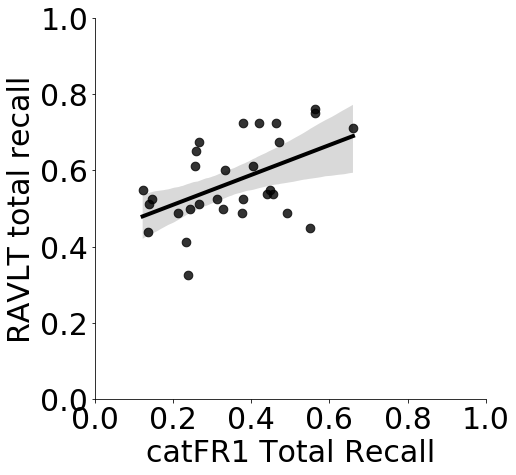

In [3]:
corr = pd.read_csv('RAVLT-cat.csv')
datadir = '/home1/radrogue/Hospital_CVLT/Graphs/'
x = corr['catFR1 Total Recall']
y = corr['RAVLT total recall']
from plotting import *
import scipy
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
set_axes(xlim = [0,1], ylim = [0,1], xticks=np.arange(0,1.1,.2), yticks=np.arange(0,1.1,.2), fontsize = 30)


datadir = '/home1/radrogue/Hospital_CVLT/Graphs/'
n = corr.Subject.nunique()
max_x = round(x.max(), 10)
min_x = round(x.min(), 1)
max_y = round(y.max(), 2)
min_y = round(y.min(), 1)
xl = x.name
yl = y.name
r, p_val = scipy.stats.pearsonr(x, y)
r, p = scipy.stats.pearsonr(x, y)
print('r({}) = {}, p = {}'.format(n-2,r,p))
g = sns.regplot(data = corr, x = x, y = y, color = 'black', ci = 95, line_kws={'linewidth':4}, scatter_kws={'s':75})

_ = plt.xlabel(xl)
_ = plt.ylabel(yl)

# plt.savefig(datadir + xl + '_' + yl + '.pdf', bbox_inches='tight')

np.save('ravlt_catfr', [r, n])